In [1]:
from keras.models import load_model

Using TensorFlow backend.


In [2]:
import os
folder_name = "models"

def load_model_helper(name):
    models = dict()
    files = sorted(os.listdir(folder_name))
    for f in files:
        if name in f:
            index = f.split("_")[1][:-3]
            models[index] = load_model("{}/{}".format(folder_name,f))
            print("{} {}".format(index,f))
    return models

In [3]:
coin_name = 'bitcoin-cash'
models = load_model_helper(coin_name)

10 bitcoin-cash_10.h5
12 bitcoin-cash_12.h5
14 bitcoin-cash_14.h5
16 bitcoin-cash_16.h5
18 bitcoin-cash_18.h5
2 bitcoin-cash_2.h5
20 bitcoin-cash_20.h5
22 bitcoin-cash_22.h5
24 bitcoin-cash_24.h5
4 bitcoin-cash_4.h5
6 bitcoin-cash_6.h5
8 bitcoin-cash_8.h5


In [4]:
from coinmarketcap_draw import coinmarketcap_data

In [5]:
ori_data = coinmarketcap_data(coin_name)

In [6]:
data = ori_data[:2000]
data.tail(5)

,market_cap,price_btc,price_usd,volume_usd,volume_token,Close
2017-12-06 10:14:00,2.498803e+10,0.117492,1483.80,1.072390e+09,722732.174147,1483.80
2017-12-06 12:14:00,2.491726e+10,0.116911,1479.59,1.072610e+09,724937.313715,1479.59
2017-12-06 14:14:00,2.476860e+10,0.115715,1470.74,1.028480e+09,699294.232835,1470.74
2017-12-06 16:14:00,2.473810e+10,0.117110,1468.91,1.008370e+09,686475.005276,1468.91
2017-12-06 17:34:00,2.547350e+10,0.118903,1512.56,1.075230e+09,710867.668059,1512.56


In [7]:
import bulbea as bb
figsize = (20, 15)
% matplotlib inline
share = bb.Share("123",'123',data=data)

/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/entity/share.py:174: UserWarning: Environment variable BULBEA_QUANDL_API_KEY for Quandl hasn't been set. A maximum of 50000 calls per day can be made. Visit https://www.quandl.com to get your API key.
  warnings.warn(message)


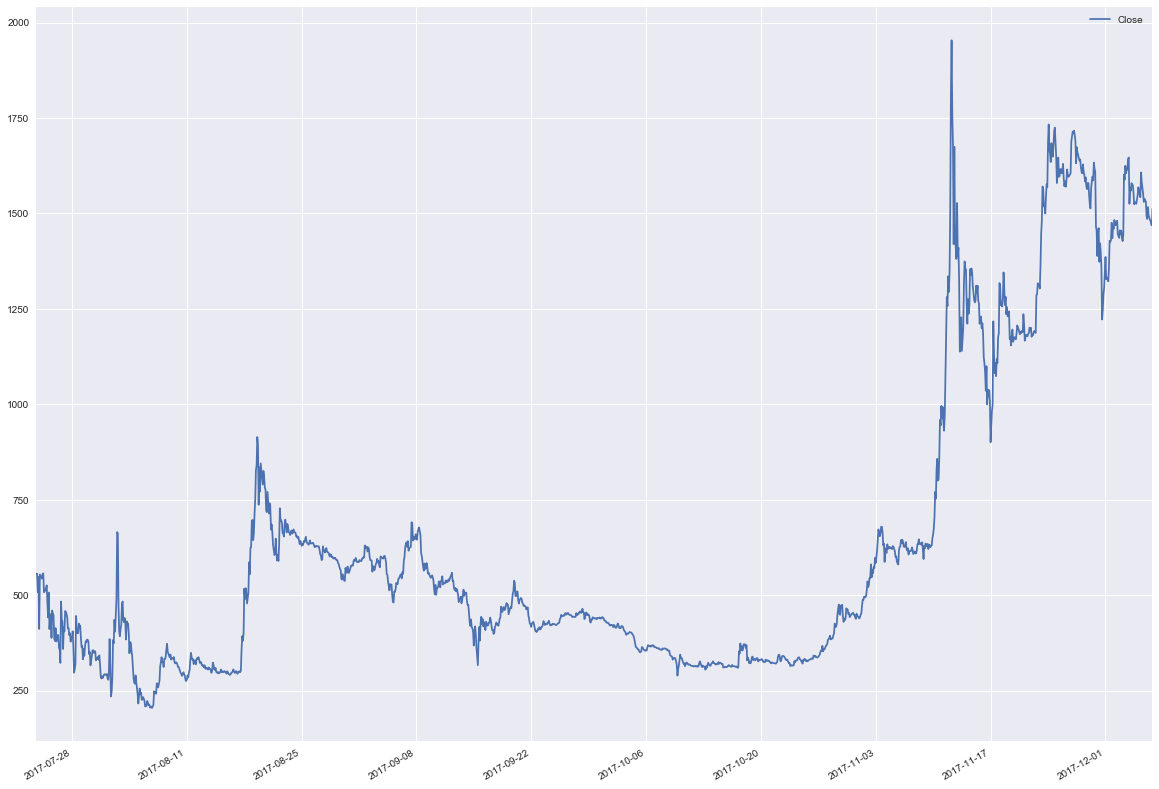

In [8]:
share.plot(figsize = figsize)

##  Convert the data to hourly

In [9]:
from datetime import timedelta
import pandas as pd

def convert_with_n_hour_gap(data,n):
    times = data.index.copy()
    first_time = times[0].to_datetime()
    v_dict = dict()
    
    for x in range(1,len(times)):
        t = times[x].to_datetime()
        if n == 24:
            success = t.day == first_time.day + 1
        else:
            success = (first_time + timedelta(hours=n)).hour == t.hour
        if success:
            first_time = t
            index = pd.Timestamp(t)
            v_dict[index] = data.loc[index]['Close']
    df = pd.DataFrame(list(v_dict.items()), columns=['Date', 'Close'])
    df.set_index("Date",inplace=True)
    return df

In [10]:
share_array = []
for i in range(1,25):
    df = convert_with_n_hour_gap(data,i)
    share = bb.Share("123",'123',data=df)
    share_array.append(share)

/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/entity/share.py:174: UserWarning: Environment variable BULBEA_QUANDL_API_KEY for Quandl hasn't been set. A maximum of 50000 calls per day can be made. Visit https://www.quandl.com to get your API key.
  warnings.warn(message)


## visualize the 24 hour data

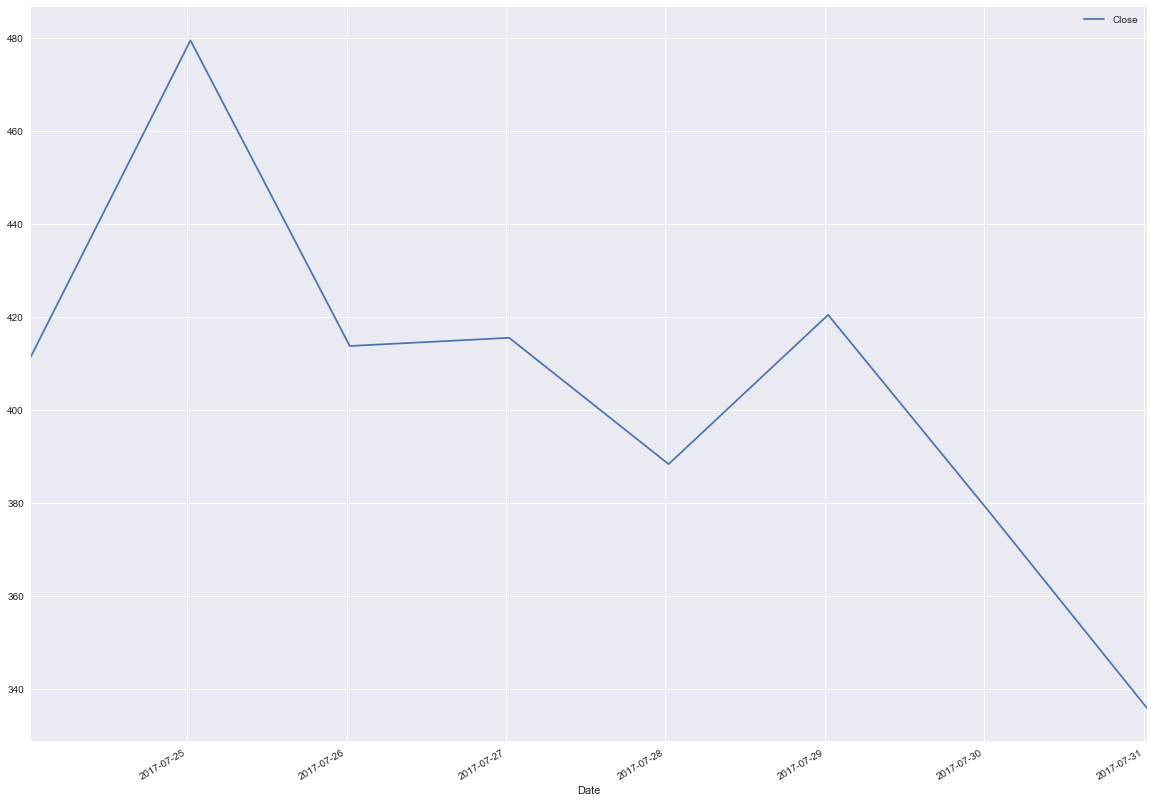

In [11]:
% matplotlib inline
share_array[-1].plot(['Close'], figsize = (20, 15), bollinger_bands = True, period = 100, bandwidth = 2)

## visualize the 1 hour data

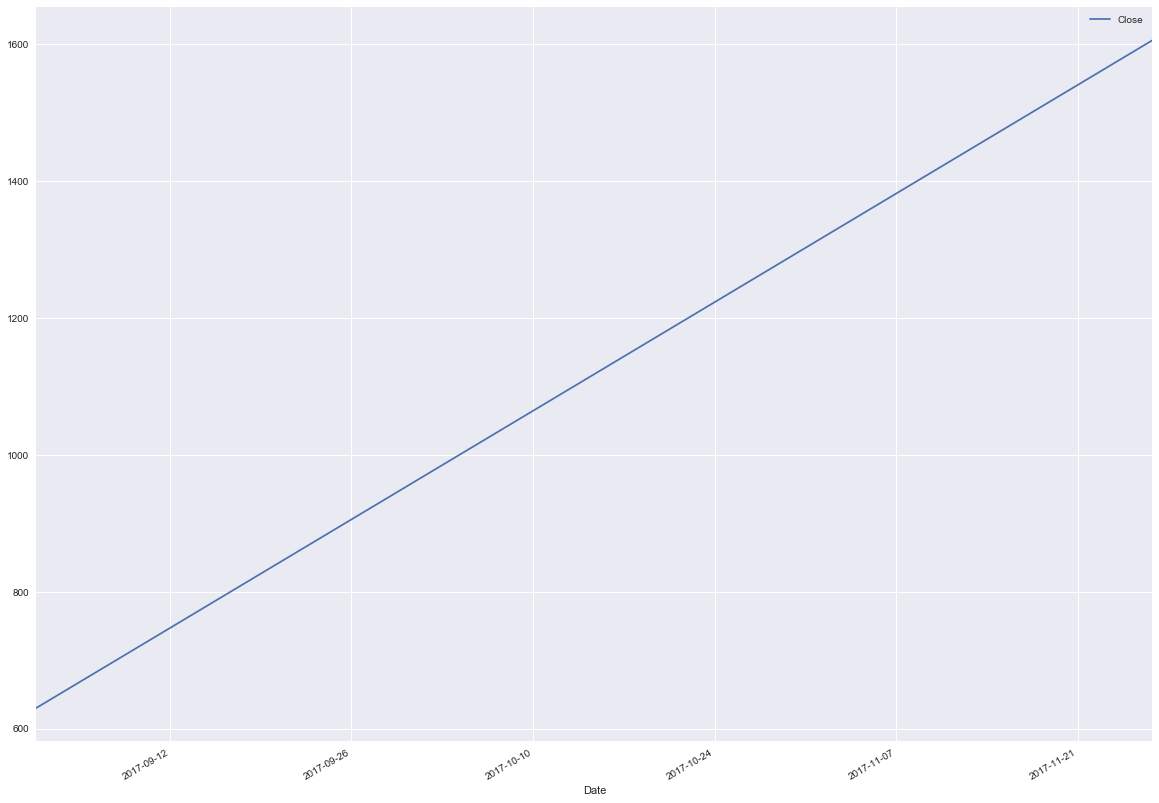

In [12]:
% matplotlib inline
share_array[0].plot(['Close'], figsize = (20, 15), bollinger_bands = True, period = 100, bandwidth = 2)

In [13]:
from bulbea.entity.share import _reverse_cummulative_return

def rever_back(ori_ytest,predicted):
    new_pre = []
    for x in range(0,len(ori_ytest)):
        t = ori_ytest[x]
        predict = predicted[x]
        new_pre.append(_reverse_cummulative_return(t,predict))
    return new_pre

In [16]:
from datetime import timedelta
import pandas as pd
from bulbea.learn.evaluation import split
import numpy as np

def predict_next_from_current_share(var_share,model):
    _, Xtest, _, ytest = split(var_share, 'Close', normalize = True, train = 0.0)
    _,ori_Xtest,_,ori_ytest = split(var_share, 'Close', normalize = False, train = 0.0)
    Xtest  = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))

    # Format the Xtest
    last_Xtest = Xtest[-1:]
    last_Xtest  = np.reshape(last_Xtest, (last_Xtest.shape[0], last_Xtest.shape[1], 1))
    
    # Format the ori_ytest
    last_ori_ytest = ori_ytest[-1]
    
    # Get the prediction
    predict = model.predict(last_Xtest)
    
    # convert it back
    new_pre = rever_back([last_ori_ytest],[predict])[0][0][0]
    return new_pre

def predict_next_n_hours(n):
    for i in range(n):
        loop_share = share_array[i]
        if str(i+1) not in models: continue
        model = models[str(i+1)]
        new_pre = predict_next_from_current_share(loop_share,model)
        print("\t\tnext {} hour price ${}".format(i+1,new_pre))

In [17]:
predict_next_n_hours(24)

6 582
6 582
		next 2 hour price $1426.6685791015625
3 291
3 291
		next 4 hour price $1468.51513671875
2 194
2 194
		next 6 hour price $1488.9287109375
2 145
2 145
		next 8 hour price $1502.8763427734375
2 115
2 115
		next 10 hour price $1505.8765869140625
2 96
2 96
		next 12 hour price $1535.4837646484375
2 82
2 82
		next 14 hour price $1491.42236328125
2 71
2 71
		next 16 hour price $1551.6221923828125
2 63
2 63
		next 18 hour price $1554.2406005859375
2 56
2 56
		next 20 hour price $1576.49462890625
2 52
2 52
		next 22 hour price $1546.25390625
2 6
2 6
		next 24 hour price $381.9559631347656


In [ ]:
data.tail(3)